In [1]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import AdamW
from torch import nn
import math

In [2]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(10,10)
    def forward(x):
        return self.layer(x)

In [3]:
network = Network()

In [12]:
optimizer = AdamW(network.parameters())

In [19]:
class CosineAnnealingWarmRestarts(_LRScheduler):

    def __init__(self, optimizer, T_0, T_mult=1, eta_min=0, last_epoch=-1, verbose=False):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        self.T_0 = T_0
        self.T_i = T_0
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.starting_lrs = [group['lr'] for group in optimizer.param_groups]

        super(CosineAnnealingWarmRestarts, self).__init__(optimizer, last_epoch, verbose)

        self.T_cur = self.last_epoch

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.starting_lrs]

    def step(self, epoch=None):

        if epoch is None and self.last_epoch < 0:
            epoch = 0

        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
        self.last_epoch = math.floor(epoch)

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False
                return self

        with _enable_get_lr_call(self):
            for i, data in enumerate(zip(self.optimizer.param_groups, self.get_lr())):
                param_group, lr = data
                param_group['lr'] = lr
                self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

In [28]:
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, 20)

In [6]:
from medvqa.losses.schedulers import create_lr_scheduler

In [13]:
lr_scheduler = create_lr_scheduler('warmup+cyclicdecay', optimizer, warmup_and_decay_args="1e-6,10,4e-4,10,1e-6", n_batches_per_epoch=400)

Using warmup+cyclicdecay scheduler: 1e-6,10,4e-4,10,1e-6
1e-06 10 0.0004 10 1e-06
self.steps_to_restart = 4000
self.steps = -1
self.initial_lr = 0.0004


In [14]:
lrs = []
for i in range(100000):
    lrs.append(optimizer.param_groups[0]['lr'])
    lr_scheduler.step()

/home/pamessina/venv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [9]:
import matplotlib.pyplot as plt

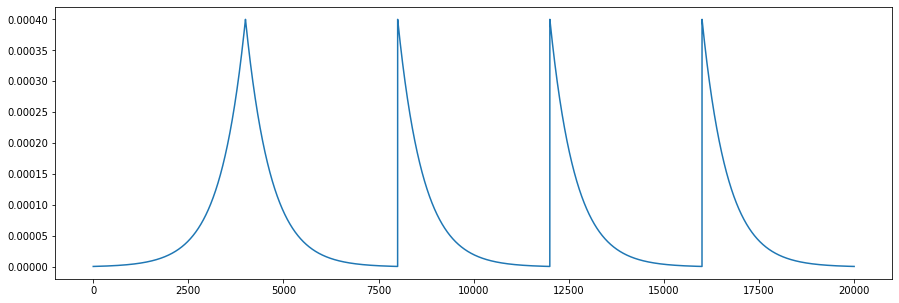

In [16]:
tmp = lrs[:20000]
plt.figure(figsize=(15, 5))
plt.plot(list(range(len(tmp))), tmp)
plt.show()